### Cab-Driver Agent

**Problem Statement:** SuperCabs is a leading app-based cab provider in a large Indian metro city.  In this highly competitive industry, retention of good cab drivers is a crucial business driver, and we believe that a sound RL-based system for assisting cab drivers can potentially retain and attract new cab drivers.

**Goal:** The goal of this project is to build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field.

**Markov's Decision Process:** Taking long-term profit as the goal, a method is built based on reinforcement learning to optimize taxi driving strategies for profit maximization. This optimisation problem is formulated as a Markov Decision Process.

**Tasks:**
- Create the environment:
- Build an agent that learns to pick the best request using DQN

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
Time_matrix[1,3,:,6]

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

#### Tracking the state-action pairs for checking convergence


In [3]:
States_track = collections.defaultdict(dict)
print(len(States_track))

0


Initialising states to be tracked to build the model

In [4]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [((3, 4, 5), (0,2)), ((4, 2, 3), (1,4))]    
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = [] 

Creating function to save the model as pkl file using pickle

In [5]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

#### Defining class Agent:

In [6]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.002
        self.epsilon_max = 1
        self.epsilon = 1
        self.epsilon_decay = 0.00025
        self.epsilon_min = 0.00001

        self.batch_size = 16
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # Initialize the value of the states tracked
        self.states_tracked = []
        self.track_state = np.array(env.state_encod_arch1([2,4,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets   
        # hidden layers
        model.add(Dense(16, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, action_space, possible_actions_index):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # in case of cartpole this will randomly choose an action between 0 and 1
            index = random.randrange(len(possible_actions_index))
            action_index = possible_actions_index[index]
            action = action_space[action_index]
            return action_index, action

        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size

            state = np.array(state).reshape(1, self.state_size)
            q_value = self.model.predict(state)
            #print("action picked from compile model = {}".format(q_value))

            return np.argmax(q_value[0]), action_space[np.argmax(q_value[0])]

    def append_sample(self, state, action, reward, next_state):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state))

    def train_model(self):
  
        if len(self.memory) < self.batch_size:
            return
        
        # Sample batch from the memory
        mini_batch = random.sample(self.memory, self.batch_size)
        update_output = np.zeros((self.batch_size, self.state_size))
        update_input = np.zeros((self.batch_size, self.state_size))

        actions, rewards = [], []
       
        
        for i in range(self.batch_size):
            
            state, action, reward, next_state = mini_batch[i]
            
            actions.append(action)
            rewards.append(reward)
            
            

            update_input[i] = env.state_encod_arch1(state)
            update_output[i] = env.state_encod_arch1(next_state)
                
        target = self.model.predict(update_input)
        target_val = self.model.predict(update_output)
        
        # get your target Q-value on the basis of terminal state
        for i in range(self.batch_size):
            target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(target_val[i]))

        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0, use_multiprocessing=True, workers=8)           
    
    def store_q_values(self):
        """ We are keeping track of q value for state [3,4,5] and action (0,2)"""
        q_value = self.model.predict(self.track_state)
        self.states_tracked.append(q_value[0][2])
            
    def save(self, name):
        self.model.save(name)   

#### Selecting episode of 5500 to train the RL model

In [7]:
Episodes = 5500

### DQN block

In [8]:
start_time = time.time()
last_end_time = time.time()
rewards_per_episode, episodes, avg_rewards_per_episode = [], [], []

env = CabDriver()

agent = DQNAgent(action_size=len(env.action_space), state_size=len(env.state_encod_arch1(
    env.state_init)))

for episode in range(Episodes):

    # Write code here
    # Call the environment
    env = CabDriver()
    score = 0
    # Call all the initialised variables of the environment
    action_space, state_space, state = env.reset()

    terminal_state = False
    t = 0
    count = 1
    while not terminal_state:
        #print("count = {}".format(count))
        count += 1
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        possible_actions_index, actions = env.requests(state)
        action_index, action = agent.get_action(env.state_encod_arch1(state), env.action_space, possible_actions_index)
        # 2. Evaluate your reward and next state
        next_state, wait_time, transit_time, ride_time = env.next_state_func(state, action,
                                                                             Time_matrix)
        reward = env.reward_func(state, action, Time_matrix)
        # 3. Append the experience to the memory
        agent.append_sample(env.state_encod_arch1(state), action_index,
                            reward, env.state_encod_arch1(next_state))
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        # 5. Keep a track of rewards, Q-values, loss
        score += reward
        state = next_state
        t += wait_time + transit_time + ride_time
        
        #  Do we need a logic to make sure that total time never goes more than 30 days. Which
        #  requires last ride to be less than the time left
        #  OR we not very hard strict with 30 days, driver can even work extra few hour just
        #  because of last ride
        if t >= 24 * 30:
            terminal_state = True

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)

    # epsilon decay
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(-agent.epsilon_decay*episode)

    # every 50th episode:
    if episode % 50 == 0:
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, Time elapsed {4}".format(episode,
                                                                           score,
                                                                           len(agent.memory),
                                                                           agent.epsilon, round(time.time()-last_end_time,0)))
        last_end_time = time.time()
    # every few episodes:
    if episode % 10 == 0:
        # store q-values of some prespecified state-action pairs
        agent.store_q_values()
    if episode % 1000 == 0:
        save_obj(agent,name='Final_model')
        elapsed_time = time.time() - start_time
        print('Total time taken ',elapsed_time)
### Keep a track of Q-values, loss

episode 0, reward -86.0, memory_length 173, epsilon 1.0, Time elapsed 21.0
INFO:tensorflow:Assets written to: model.pkl\assets
Total time taken  21.34783124923706
episode 50, reward -280.0, memory_length 2000, epsilon 0.9875779247158765, Time elapsed 862.0
episode 100, reward -343.0, memory_length 2000, epsilon 0.9753101589292124, Time elapsed 860.0
episode 150, reward 42.0, memory_length 2000, epsilon 0.9631947857766446, Time elapsed 885.0
episode 200, reward -137.0, memory_length 2000, epsilon 0.951229912206469, Time elapsed 858.0
episode 250, reward -200.0, memory_length 2000, epsilon 0.9394136686828477, Time elapsed 856.0
episode 300, reward -243.0, memory_length 2000, epsilon 0.9277442088936896, Time elapsed 850.0
episode 350, reward -42.0, memory_length 2000, epsilon 0.916219709462161, Time elapsed 846.0
episode 400, reward -243.0, memory_length 2000, epsilon 0.9048383696617791, Time elapsed 840.0
episode 450, reward 4.0, memory_length 2000, epsilon 0.8935984111350446, Time elaps

episode 4100, reward 110.0, memory_length 2000, epsilon 0.3588028774412976, Time elapsed 711.0
episode 4150, reward 49.0, memory_length 2000, epsilon 0.3543458807363474, Time elapsed 728.0
episode 4200, reward 6.0, memory_length 2000, epsilon 0.3499442497336642, Time elapsed 704.0
episode 4250, reward -189.0, memory_length 2000, epsilon 0.3455972966694488, Time elapsed 711.0
episode 4300, reward 186.0, memory_length 2000, epsilon 0.3413043423234407, Time elapsed 714.0
episode 4350, reward 328.0, memory_length 2000, epsilon 0.33706471591278936, Time elapsed 701.0
episode 4400, reward -442.0, memory_length 2000, epsilon 0.3328777549872426, Time elapsed 704.0
episode 4450, reward -51.0, memory_length 2000, epsilon 0.32874280532563727, Time elapsed 722.0
episode 4500, reward 1.0, memory_length 2000, epsilon 0.32465922083367615, Time elapsed 719.0
episode 4550, reward 278.0, memory_length 2000, epsilon 0.3206263634429743, Time elapsed 721.0
episode 4600, reward 108.0, memory_length 2000, ep

In [9]:
elapsed_time = time.time() - start_time
print('Total time taken ',elapsed_time)

Total time taken  83221.3116543293


### Tracking Convergence

#### Plotting Total Rewards:

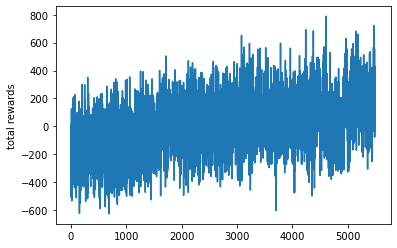

In [10]:
# Check Convergence by tracking total rewards per episode vs episode number
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.ylabel("total rewards")
plt.show()

In [11]:
# Average reward per 100 episode
avg_rewards = []
episodes = len(rewards_per_episode)
index = 0
track_total_reward = 0
for episode_number in range(episodes):
    if index != 100:
        track_total_reward += rewards_per_episode[episode_number]
        index += 1
    else:
        avg_rewards.append(track_total_reward/index)
        track_total_reward = rewards_per_episode[episode_number]
        index = 1

avg_rewards.append(track_total_reward/index)
        
    
print(avg_rewards)

[-185.44, -164.13, -147.83, -122.06, -145.47, -147.55, -160.34, -122.04, -115.67, -109.01, -104.37, -116.51, -48.39, -68.74, -91.91, -75.41, -18.53, -13.86, 12.84, -30.15, -10.83, 38.86, -9.65, 28.79, -8.87, 4.76, 31.44, 40.47, 18.54, 75.22, 52.31, 104.31, 117.14, 42.83, 80.29, 57.62, 85.97, 68.26, 40.92, 68.76, 36.47, 69.89, 94.75, 88.93, 175.18, 112.46, 37.37, 4.5, -34.78, 146.58, 133.09, 226.08, 153.78, 128.18, 186.36]


#### Plotting Average rewards:

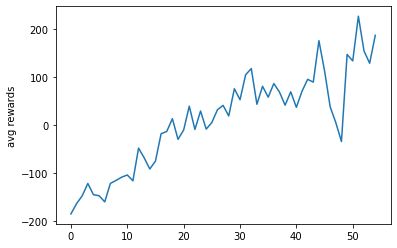

In [12]:
## Check Convergence by tracking average rewards per episode vs episode number
plt.plot(list(range(len(avg_rewards))), avg_rewards)
plt.ylabel("avg rewards")
plt.show()

#### Plotting Q Value for the sample state:

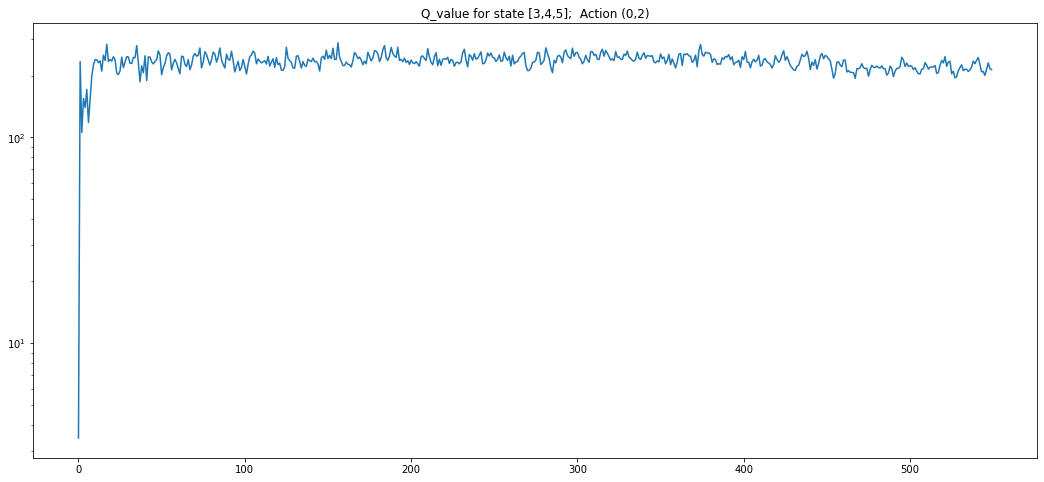

In [16]:
plt.figure(0, figsize=(18,8))
plt.title('Q_value for state [3,4,5];  Action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [19]:
time = np.arange(0,5500)
epsilon = []
for i in range(0,5500):
    epsilon.append(0 + (1 - 0) * np.exp(-0.00025*i))

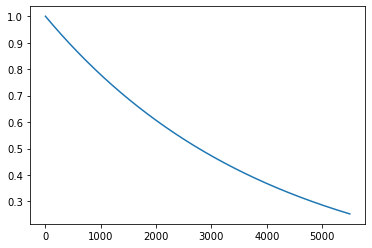

In [20]:
plt.plot(time, epsilon)
plt.show()

**Summary:** So we were able to create the environment and an RL agent that learns to choose the best request.